Define Hyperparameters and Paths (Then You Can Just Run All of the Cells)

In [57]:
WELLS = ["CCS1", "VW1"]       #wells being used
EPOCHS = 50                   #number of iterations picking batch worth of sequences
BATCH_SIZE = 32               #how much data you pass in at once
LR = 0.01                     #learning rate
BIDIRECTIONAL_STATUS = True   #whether LSTM considers future depths
HIDDEN_SIZE = 16              #num features in hidden state
SEQ_LEN = 32                  #length of sequence
NUM_LSTM_LAYERS = 1           #number of LSTM layers
DROP_P = 0.2                  #probability that neuron is turned off in dropout layer to prevent overfitting
FRAC_THRESHOLD = 0.2          #probability needed to qualify a fracture for metric computation

FORMATIONS = [                #formations considered in model (comment out ones you want to ignore)
    "Eau Claire",
    "Mt. Simon E",
    "Mt. Simon D",
    "Mt. Simon C",
    "Mt. Simon B",
    "Mt. Simon A",
    "Argenta",
    "Precambrian"
    ]


DATALOGS_PATH = "REU Project/Data/Raw CSV Files/raw_"
LABELS_PATH = "REU Project/Data/labels/label_"
MODEL_DUMP_PATH = "REU Project/Models/LSTM/"

Imports

In [58]:
import numpy as np
from tqdm import tqdm

from sklearn.metrics import precision_score, recall_score, f1_score, \
accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import time
import matplotlib.pyplot as plt
import math
import pandas as pd
import joblib
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

Retrieve Data and Labels

In [59]:
datalogs = {}
labels = {}
datasets = {}
num_features = 0
for well in WELLS:
  datalogs_df = pd.read_csv(DATALOGS_PATH + well + ".csv")
  labels_df = pd.read_csv(LABELS_PATH + well + ".csv")

  #filter rock formations considered
  datalogs_df = datalogs_df[datalogs_df["FORM"].isin(FORMATIONS)]

  datalogs[well] = datalogs_df
  labels[well] = labels_df
  num_features = len(datalogs_df.columns) - 2 #exclude DEPT and FORM

  dataset = pd.merge(datalogs_df, labels_df, on='DEPT') #merge data and labels
  datasets[well] = dataset

  print(f"{well} : Shape of inputs= {datalogs_df.shape}")
  print(f"{well} : Shape of labels= {labels_df.shape}")
  print(f"{well} : Shape of merged= {dataset.shape}")

print(f"Num features: {num_features}")

CCS1 : Shape of inputs= (4217, 24)
CCS1 : Shape of labels= (4217, 2)
CCS1 : Shape of merged= (4217, 25)
VW1 : Shape of inputs= (3999, 24)
VW1 : Shape of labels= (3999, 2)
VW1 : Shape of merged= (3999, 25)
Num features: 22


Optional Data Preprocessing Tools (Comment out function calls in final cell if you don't want to use)

In [60]:
def normalize(X_train, X_test):
  """
  Fit normalization to training data and apply to test data. Choose standard
  standard or MinMax Scaler.
  """
  scaler = StandardScaler()
  #scaler = MinMaxScaler(feature_range=(0, 1))
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  return X_train, X_test

In [61]:
def balance_dataset(dataset):
  """
  Undersample negative class to address bias in database. Adjust rat variable
  to change ratio of negative class to positive class data points.
  """
  df_0 = dataset[dataset['HAS_FRAC'] == 0]
  df_1 = dataset[dataset['HAS_FRAC'] == 1]

  # Randomly sample majority class so that it has rat times more data points
  # than minority class
  rat = 2
  min_samples = min(len(df_0), len(df_1))
  df_0_sampled = df_0.sample(n=min_samples * rat, replace=False)
  df_1_sampled = df_1.sample(n=min_samples, replace=False)

  # Concatenate the sampled DataFrames and shuffle
  balanced_df = pd.concat([df_0_sampled, df_1_sampled])
  balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
  return balanced_df

In [62]:
def apply_PCA(X_train, X_test):
  """
  Returns components that explain n% of the data's variance. Adjust n variable
  to change what percentage of variance should be included. There is a more
  detailed analysis in the PCA analysis notebook.
  """
  print(f"Before PCA Xtrain, Xtest shapes: {X_train.shape}, {X_test.shape}")
  n = 0.8
  pca = PCA()
  train_pca_data = pca.fit_transform(X_train)
  test_pca_data = pca.transform(X_test)

  variance_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
  cumulative_variance_explained = np.cumsum(variance_explained)
  n_components = np.argmax(cumulative_variance_explained >= n) + 1

  new_X_train = train_pca_data[:, :n_components]
  new_X_test = test_pca_data[:, :n_components]
  print(f"After PCA Xtrain, Xtest shapes:\
   {new_X_train.shape}, {new_X_test.shape}")
  return new_X_train, new_X_test

Result Evaluation Tools

In [63]:
def plot_train_test_loss(training_losses, testing_losses):
  """
  Plots loss over epochs.
  """
  plt.plot(training_losses, label = "training losses")
  plt.plot(testing_losses, label = "testing losses")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

In [64]:
def plot_depths_with_labels(curr_well, test_dataloader, label_df):
  """
  Runs dataset through the model. Since depths may be passed through the model
  multiple times in a LSTM (because sequence randomly sampled repeatedly), keeps
  track of most common classification (intact or fractured) for each depth in
  label_count and pred_count as dataset is passed through. Then, the results are
  plotted.
  """
  model = joblib.load(MODEL_DUMP_PATH + curr_well + ".joblib")

  plt.figure(figsize=(8, 6))
  plt.ylabel("Depth [ft]")
  plt.title("Test Well: " + curr_well)
  plt.xticks([])

  pred_count = {}
  with torch.no_grad():
     for data, labels, test_dept in test_dataloader:
          y_pred = model(data).squeeze() #passes data through model
          for ys, depts in zip(y_pred, test_dept):
            #normalize y's
            y_pred_max = max(max(ys), 1)
            for i in range(len(ys)):
              ys[i] = abs(ys[i] / y_pred_max)

            #set a threshold for what is qualified as a fracture
            for y, dept in zip(ys.numpy(), depts.numpy()):
              if y > FRAC_THRESHOLD:
                to_add_y = 1
              else:
                to_add_y = -1

              # keep track of number indicating which classification (intact or
              # fractured) is more prevalent for each depth
              if dept not in pred_count.keys():
                pred_count[dept] = to_add_y
              else:
                curr_y = pred_count[dept] + to_add_y
                pred_count[dept] = curr_y

  #compresses label_df and dept_count into lists containing binary indication
  #if depth is fractured or not
  plot_depths = []
  plot_labels = []
  plot_preds = []
  for dept in pred_count.keys():
    if pred_count[dept] > 0:
      plot_preds.append(-1)
    else:
      plot_preds.append(0)
    plot_labels.append(
                   label_df.loc[label_df['DEPT'] == dept, 'HAS_FRAC'].values[0])
    plot_depths.append(dept)

  #plot results
  plt.barh(plot_depths, plot_preds, color="blue")
  plt.barh(plot_depths, plot_labels, color="gray")

  plt.gca().invert_yaxis()
  mind = math.floor(int(min(plot_depths)) / 250) * 250
  maxd = math.floor(int(max(plot_depths)) / 250) * 250
  plt.ylim(mind, maxd)
  plt.yticks(range(mind, maxd, 250))
  plt.xticks([])
  #plt.savefig(curr_well + '_LSTMPlot.png', format='png', dpi=1200)
  plt.show()
  print(f"Predicted num fractured depths: {-1 * sum(plot_preds)}, \
  true num fractured depths: {sum(plot_labels)}")

In [65]:
def evaluate_performance(curr_well, dataset, show_precision_recall=False,
                         show_numfracs=False):
  """
  Passes dataset through model and prints metrics indicating its performance.
  By default, only displays accuracy and F1 but can also display precision,
  recall, and the number of fractures predicted.
  """
  model = joblib.load(MODEL_DUMP_PATH + curr_well + ".joblib")

  pred_frac = 0
  act_frac = 0
  accuracies = []
  precisions = []
  recalls = []
  f1s = []

  with torch.no_grad(): #passes data through pre-trained model
      for data, labels, test_dept in dataset:
        y_pred = model(data).squeeze()
        for ys, labels, depts in zip(y_pred, labels, test_dept):
          #normalize y's
          y_pred_max = max(max(ys), 1)
          for i in range(len(ys)):
            ys[i] = abs(ys[i] / y_pred_max)

          #enact threshold for what is qualified as a fracture
          y_pred_rounded = []
          for y in ys:
            if y > FRAC_THRESHOLD:
              y_pred_rounded.append(1)
            else:
              y_pred_rounded.append(0)

          #keep track of metrics
          pred_frac += sum(y_pred_rounded)
          act_frac += sum(labels)
          accuracies.append(accuracy_score(labels, y_pred_rounded))
          if show_precision_recall:
            precisions.append(precision_score(labels,
                                              y_pred_rounded,
                                              average="macro"))
            recalls.append(recall_score(labels,
                                        y_pred_rounded,
                                        average="macro"))
          f1s.append(f1_score(labels, y_pred_rounded, average="macro"))

  #display metrics
  print(f"Accuracy = {(np.mean(accuracies) * 100).round(2)}%")
  if show_precision_recall:
    print(f"Precision = {(np.mean(precisions) * 100).round(2)}%")
    print(f"Recall = {(np.mean(recalls) * 100).round(2)}%")
  print(f"F1 = {(np.mean(f1s) * 100).round(2)}%")

  if show_numfracs:
    print(f"Predicted num fractured depths: {pred_frac}, Actual num fractured \
    depths: {act_frac} (not accounting for seq duplicates)")

Feed Forward Network Class

In [66]:
class LSTMNet(nn.Module):
  """
  Long Short-Term Memory Class that looks at sequence of data at once.
  """
  def __init__(self, n_components):
    super().__init__()
    self.lstm = nn.LSTM(input_size=n_components,
                        hidden_size=HIDDEN_SIZE,
                        num_layers=NUM_LSTM_LAYERS,
                        bidirectional=BIDIRECTIONAL_STATUS,
                        batch_first=True)
    if BIDIRECTIONAL_STATUS: #double hidden size for bidirectionality
      self.fc1 = nn.Linear(HIDDEN_SIZE * 2, 1)
    else:
      self.fc1 = nn.Linear(HIDDEN_SIZE, 1)
    self.dropout = nn.Dropout(p=DROP_P)

  def forward(self, x):
    #passes data through LSTM, dropout later, and linear layer
    x, _ = self.lstm(x)
    output = self.dropout(x)
    output = self.fc1(x)
    return output

Class For Custom Dataset Compatible with LSTM

In [67]:
class CustomDataset(Dataset):
  """
  LSTM datset allows code to grab SEQ_LEN depths at a time for training/testing
  """
  def __init__(self, features, labels, test_depths=[]):
    self.features = features
    self.labels = labels
    self.seq_len = SEQ_LEN
    self.test_depths = test_depths

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    """
    Grab random sequence of SEQ_LEN depths and corresponding data.
    """
    x = torch.tensor(self.features, dtype=torch.float32)
    y = torch.tensor(self.labels, dtype=torch.long)
    if len(x) > self.seq_len: #check to make sure data is longer than seq len
      diff = len(x) - self.seq_len
      start_idx = np.random.randint(diff)
      x = x[start_idx:start_idx+self.seq_len]
      y = y[start_idx:start_idx+self.seq_len]

    #keep track of depth sequence if dataset is testset for later plotting
    if len(self.test_depths) == 0: #train data case
      test_depths = torch.zeros_like(y)
    else: #test data case
      test_depths = torch.tensor(self.test_depths[start_idx:start_idx+ \
                                 self.seq_len], dtype=torch.float32)
    return x, y, test_depths

Train/Test Loop

In [68]:
def train_test_loop(curr_well, trainset, testset, n_components, verbose=True):
  """
  Constructs a LSTM model. It passes training data through model, calculates
  loss, then updates model. Then, it passes testing data through the model and
  plots the loss over epochs. It prints metrics indicating the model's
  performance every 5 epochs.
  """
  model = LSTMNet(n_components).to(DEVICE)
  optimizer = optim.Adam(model.parameters(), lr = LR)
  loss_fxn = nn.MSELoss() #mean squared error loss

  training_losses = []
  testing_losses = []
  for epoch in range(EPOCHS):
    training_loss_per_epoch = []
    testing_loss_per_epoch = []

    ## TRAINING LOOP ##
    model.train()
    for data, labels, _ in trainset:
      data, labels = data.to(DEVICE), labels.to(DEVICE)
      optimizer.zero_grad()
      y_pred = model(data).squeeze()
      loss = loss_fxn(y_pred, labels.float())
      training_loss_per_epoch.append(loss.item())
      loss.backward()
      optimizer.step()

    ## VALIDATION LOOP ##
    model.eval()
    for data, labels, test_depths in testset:
      with torch.no_grad():
        data, labels = data.to(DEVICE), labels.to(DEVICE)
        y_pred = model(data).squeeze()
        loss = loss_fxn(y_pred, labels.float())
        testing_loss_per_epoch.append(loss.item())

    #average losses over epoch for each set and plot them
    training_losses.append(np.mean(training_loss_per_epoch))
    testing_losses.append(np.mean(testing_loss_per_epoch))

    #save model
    joblib.dump(model, MODEL_DUMP_PATH + curr_well + ".joblib")

    #occasionally print accuracy/f1 progress
    if epoch %5 == 0 and verbose:
      print(f"\nEpoch - {epoch}")
      print(f"\nTrain:")
      evaluate_performance(curr_well, trainset, show_numfracs=True)
      print(f"\nTest:")
      evaluate_performance(curr_well, testset, show_numfracs=True)

  #plot final training and testing losses
  plot_train_test_loss(training_losses, testing_losses)
  return model

Run Model on All Combinations of Wells


Training on ['VW1'],  testing on CCS1

Epoch - 0

Train:
Accuracy = 89.8%
F1 = 79.27%
Predicted num fracs: 20614, Actual num fracs: 18155    (not accounting for seq duplicates)

Test:
Accuracy = 74.14%
F1 = 59.43%
Predicted num fracs: 22614, Actual num fracs: 18841    (not accounting for seq duplicates)


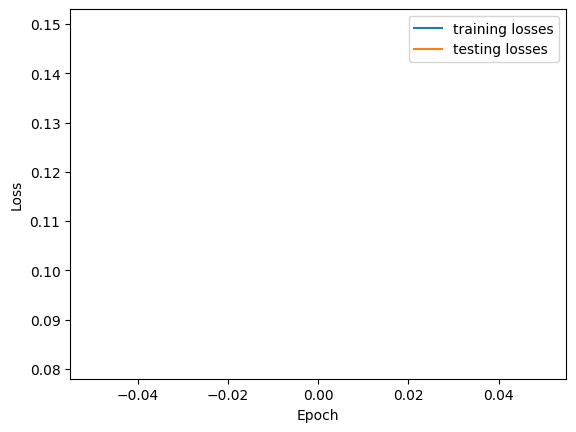


Final Training results:
Accuracy = 89.47%
Precision = 80.33%
Recall = 79.98%
F1 = 78.75%
Predicted num fracs: 20651, Actual num fracs: 18715    (not accounting for seq duplicates)

Final Testing results:
Accuracy = 73.54%
Precision = 62.8%
Recall = 58.55%
F1 = 58.48%
Predicted num fracs: 23566, Actual num fracs: 19143    (not accounting for seq duplicates)


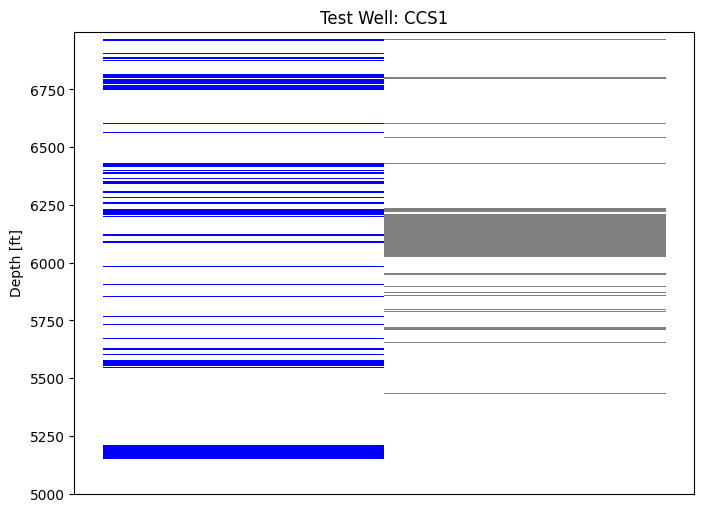

Predicted num fractures: 733,   true num fractures: 603

Training on ['CCS1'],  testing on VW1

Epoch - 0

Train:
Accuracy = 86.63%
F1 = 75.63%
Predicted num fracs: 29115, Actual num fracs: 20422    (not accounting for seq duplicates)

Test:
Accuracy = 57.46%
F1 = 45.63%
Predicted num fracs: 49577, Actual num fracs: 18337    (not accounting for seq duplicates)


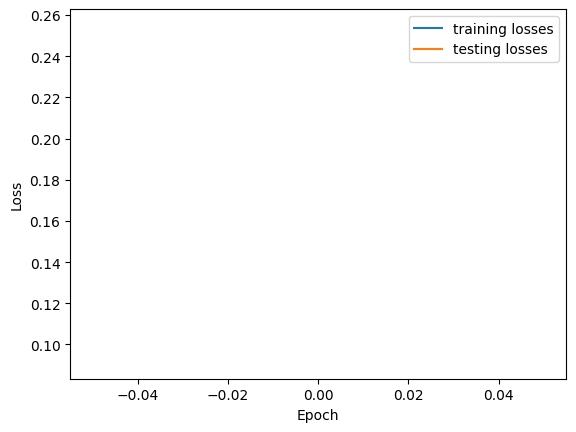


Final Training results:
Accuracy = 87.05%
Precision = 78.42%
Recall = 76.48%
F1 = 75.96%
Predicted num fracs: 27481, Actual num fracs: 18986    (not accounting for seq duplicates)

Final Testing results:
Accuracy = 57.98%
Precision = 50.22%
Recall = 49.27%
F1 = 46.4%
Predicted num fracs: 49706, Actual num fracs: 17112    (not accounting for seq duplicates)


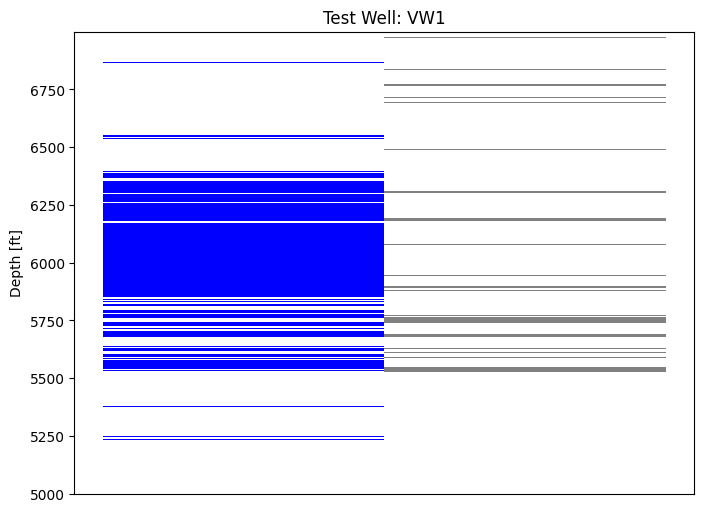

Predicted num fractures: 1466,   true num fractures: 569


In [69]:
### run on gpu if you can to go faster
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

for i in range(len(WELLS)):
  ### iterate through which well is used for testing (rest used for training)
  curr_well = WELLS[i]
  test = datasets[curr_well]
  trains = [datasets[well] for well in WELLS if well != curr_well]
  train = pd.concat(trains)
  test_depths = np.array(test["DEPT"])

  ### optional undersampling of majority class
  #train = balance_dataset(train)

  train_data = np.array(train.drop(columns=["HAS_FRAC", "DEPT", "FORM"], axis=1))
  train_labels = np.array(train["HAS_FRAC"])
  test_data = np.array(test.drop(columns=["HAS_FRAC", "DEPT", "FORM"], axis=1))
  test_labels = np.array(test["HAS_FRAC"])

  ### optional data preprocessing steps
  train_data, test_data = normalize(train_data, test_data)
  #train_data, test_data = apply_PCA(train_data, test_data)

  ### make custom datasets to feed into dataloader
  n_components = train_data.shape[1]
  trainset = CustomDataset(train_data, train_labels)
  testset = CustomDataset(test_data, test_labels, test_depths)

  ### make dataloader objects that work with Pytorch
  train_dataloader = torch.utils.data.DataLoader(trainset,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True)
  test_dataloader = torch.utils.data.DataLoader(testset,
                                                batch_size=BATCH_SIZE,
                                                shuffle=False)

  ### train/test model and display results
  print(f"\nTraining on {[well for well in WELLS if well != curr_well]},\
  testing on {curr_well}")
  train_test_loop(curr_well,
                  train_dataloader,
                  test_dataloader,
                  n_components,
                  verbose=True)

  print("\nFinal Training results:")
  evaluate_performance(curr_well,
                       train_dataloader,
                       show_precision_recall=True,
                       show_numfracs=True)
  print("\nFinal Testing results:")
  evaluate_performance(curr_well,
                       test_dataloader,
                       show_precision_recall=True,
                       show_numfracs=True)
  plot_depths_with_labels(curr_well, test_dataloader, \
                          test[["DEPT", "HAS_FRAC"]])